Analysis code from PyPSA-BO

https://github.com/CIE-UMSS/PyPSA-BO/blob/main/Results_analysis/EnergyScope-PyPSA/general_analysis.ipynb

In [42]:
#Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)



max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

#Load different networks

base_network= "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources 

added_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec.nc"
n_add = pypsa.Network(added_network) #output from add_electricity. network with electrical parameters added to components in data sources 

simplified_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #output simplyfy_network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = 'C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s_all.nc'
n_cluster = pypsa.Network(clustered_network) #output clustering-network simplified based on number of clusters give

solved_network = r'C:\Users\hie\pe_tan\pypsa-earth\results\2040_base\networks\elec_s_all_ec_lcopt_1h.nc'
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


In [43]:
# System cost in Million EUR/Year

system_cost_million_eur = n.objective / 1e6  # Convert to million EUR/year

# Print the result
print(f"System cost: {system_cost_million_eur:.2f} Million EUR/Year")

System cost: 13050314.83 Million EUR/Year


In [44]:
#check lines

n_solve.lines.capital_cost.sum()


385359.6767738733

In [45]:
n_add.lines.capital_cost.sum()

480816.53976495634

In [46]:
line_expansion_cost = n.lines.capital_cost.sum()-n_simple.lines.capital_cost.sum() # difference between the two networks (Eur/MW)
print("Capital cost for line expansion: " + str(line_expansion_cost/1000000) + " Million Eur")

Capital cost for line expansion: -0.09545686299108307 Million Eur


In [47]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.p_nom


carrier
CCGT          1.192700e+03
OCGT          1.850000e+02
biomass       1.050000e+01
coal          6.000000e+02
geothermal    1.350000e+02
load          6.700000e+10
offwind-ac    0.000000e+00
offwind-dc    0.000000e+00
oil           8.880000e+01
onwind        9.110989e-01
ror           6.017862e+02
solar         1.447202e+01
Name: p_nom, dtype: float64

In [48]:
#optimized

gen_cap.p_nom_opt

carrier
CCGT          1.348857e+03
OCGT          1.855272e+02
biomass       1.061604e+01
coal          6.000010e+02
geothermal    8.613686e+03
load          6.700000e+10
offwind-ac    2.714196e+00
offwind-dc    1.502706e+00
oil           8.964852e+01
onwind        1.764118e+05
ror           6.017862e+02
solar         1.491341e+05
Name: p_nom_opt, dtype: float64

In [49]:
stores_cap = n.storage_units.groupby(["carrier"]).sum()
stores_cap.p_nom_opt

carrier
hydro    4340.625972
Name: p_nom_opt, dtype: float64

In [50]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT             156.157088
OCGT               0.527218
biomass            0.116036
coal               0.000965
geothermal      8478.685942
load               0.000000
offwind-ac         2.714196
offwind-dc         1.502706
oil                0.848517
onwind        176410.919375
ror                0.000000
solar         149119.616533
dtype: float64

In [51]:
generation_expansion.sum()

334171.0885750714

Transmission expansion

In [52]:

n_line = pypsa.Network(base_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


458.9607745961448

In [53]:
lines=n.lines
n.lines.s_nom.mean()

458.9607745961448

In [54]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
0     5.442862e+01
1     2.058411e+02
2     1.947739e+01
3     5.461092e+03
4     1.874702e+02
          ...     
66    4.514540e+02
67   -1.081389e-09
68    1.069829e-01
69    3.136359e+02
70    4.514543e+02
Length: 71, dtype: float64

In [84]:
# Calculate transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']

# Filter for negative values
negative_expansion = transmission_expansion[transmission_expansion < 0]

# Print the negative values
print("Negative transmission expansions:")
print(negative_expansion)

# Count the number of negative values
print(f"Number of negative expansions: {len(negative_expansion)}")

# Sum of negative expansions
print(f"Total negative expansion (MW): {negative_expansion.sum()}")

Negative transmission expansions:
Line
67   -1.081389e-09
dtype: float64
Number of negative expansions: 1
Total negative expansion (MW): -1.0813892004080117e-09


In [55]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 45496.43945800929


In [56]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

5461.091540420753

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2452526199.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



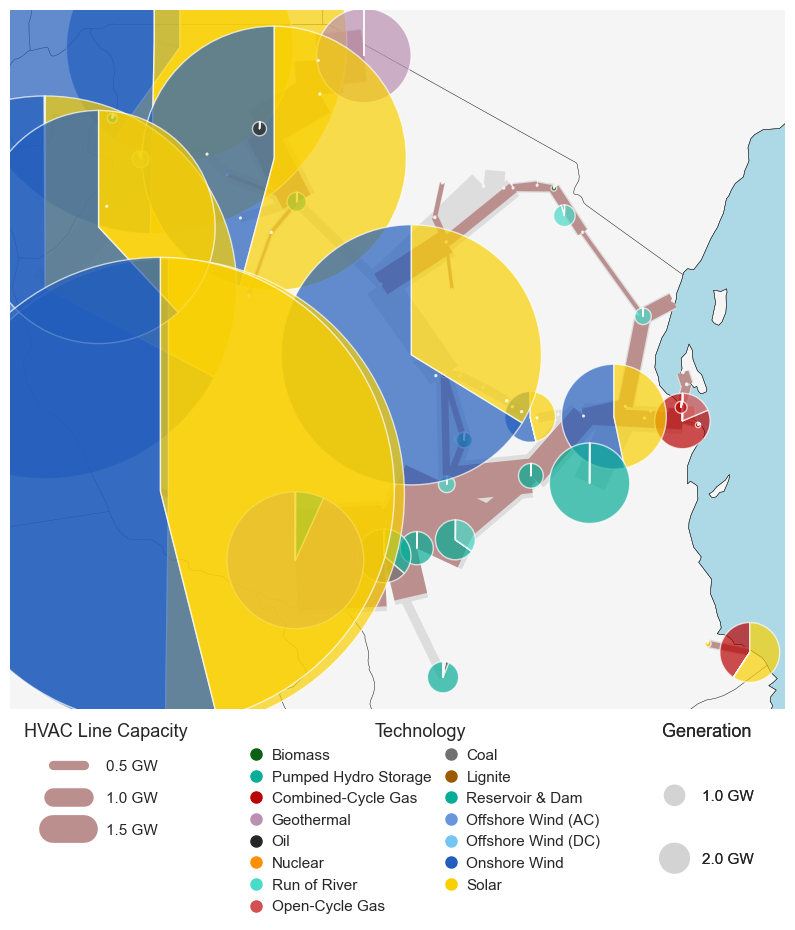

In [57]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    



    add_legend(ax, bus_factor, branch_factor)

    


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [58]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Biomass                 1.061604e+01        1.050000e+01   
            Coal                    6.000010e+02        6.000000e+02   
            Combined-Cycle Gas      1.348857e+03        1.192700e+03   
            Geothermal              8.613686e+03        1.350000e+02   
            Offshore Wind (AC)      2.714196e+00        0.000000e+00   
            Offshore Wind (DC)      1.502706e+00        0.000000e+00   
            Oil                     8.964852e+01        8.880000e+01   
            Onshore Wind            1.764118e+05        9.110989e-01   
            Open-Cycle Gas          1.855272e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   1.491341e+05        1.447202e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      7.808265e+04        3.258621e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Biomass             1.111141e+04  0.000000e+00  1.111141e+04   
            Coal                1.037741e+03  0.000000e+00  1.037741e+03   
            Combined-Cycle Gas  2.056664e+06  0.000000e+00  2.056664e+06   
            Geothermal          6.382050e+07  0.000000e+00  6.382050e+07   
            Offshore Wind (AC)  2.490367e+03  0.000000e+00  2.490367e+03   
            Offshore Wind (DC)  2.029175e+03  0.000000e+00  2.029175e+03   
            Oil                 3.671624e+03  0.000000e+00  3.671624e+03   
            Onshore Wind        4.303698e+06  0.000000e+00  4.303698e+06   
            Open-Cycle Gas      7.218763e+02  0.000000e+00  7.218763e+02   
            Run of River        2.009822e+05  0.000000e+00  2.009822e+05   
            Solar               5.592319e+06  0.000000e+00  5.592319e+06   
            load                1.627481e+06  0.000000e+00  1.627481e+06   
Line        AC                  3.988039e+08  3.988039e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.227298e+06  0.000000e+00  1.227298e+06   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Biomass             0.000000e+00         0.119482  0.000000e+00   
            Coal                0.000000e+00         0.000197  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.174058  0.000000e+00   
            Geothermal          0.000000e+00         0.845799  0.000000e+00   
            Offshore Wind (AC)  0.000000e+00         0.104741  2.039647e+03   
            Offshore Wind (DC)  0.000000e+00         0.154149  1.697923e+03   
            Oil                 0.000000e+00         0.004675  0.000000e+00   
            Onshore Wind        0.000000e+00         0.002785  6.978539e+07   
            Open-Cycle Gas      0.000000e+00         0.000444  0.000000e+00   
            Run of River        0.000000e+00         0.038125  8.049368e+04   
            Solar               0.000000e+00         0.004281  2.065145e+08   
            load                0.000000e+00         0.000003  0.000000e+00   
Line        AC                 -7.836034e+07         0.583043  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.032277  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Biomass                    3.755884e+06             1.759858e+05   
            Coal                       2.649000e+08             3.344040e+04   
            Combined-Cycle Gas         1.702013e+08             9.627768e+07   
            Geothermal                 0.000000e+00             5.824388e+05 

In [59]:
n.statistics.dispatch().sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\3758984340.py:1: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



0.2209244091063738

In [60]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

31252716496.437748

In [61]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

31252.71649643775

In [62]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

13019961.66573586

In [63]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

30353.160620171344

<AxesSubplot:xlabel='snapshot'>

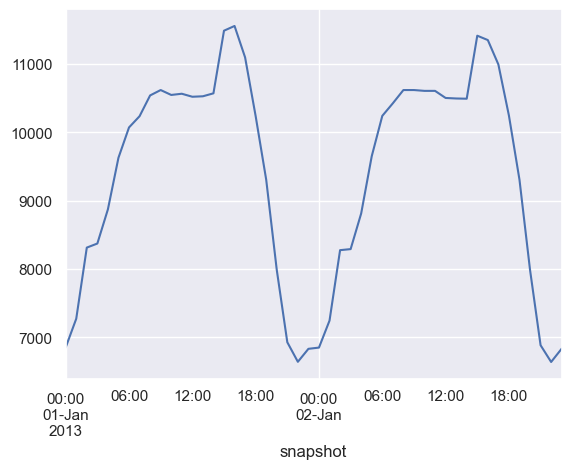

In [64]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

Expansion and generation charts

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\3549183427.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

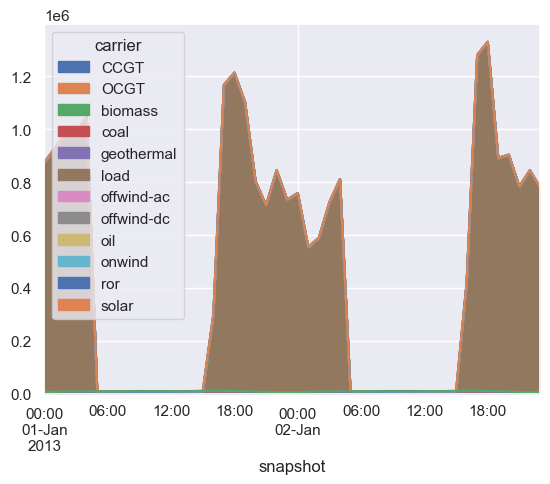

In [65]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.generators_t.p.loc[date1:date2].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

In [66]:
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"]   #constraint
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"].groupby(n.generators.carrier, axis=1).mean()  #resource availability
n.generators.marginal_cost 

curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment.loc["2013-01-01 06:00":"2013-01-01 15:00"].sum(axis=1)

n.generators_t.p.loc[:, n.generators.carrier == "load"].loc["2013-01-01 06:00":"2013-01-01 15:00"]   #load shedding



n.generators[["p_nom", "p_nom_opt"]]    #status

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2573341186.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



,p_nom,p_nom_opt
Generator,,
C31,9.000000e+00,9.030763e+00
C32,1.500000e+00,1.585274e+00
C33,1.020000e+02,1.020091e+02
C34,1.890000e+02,1.890654e+02
C35,1.290000e+02,1.290981e+02
...,...,...
79 load,1.000000e+09,1.000000e+09
80 load,1.000000e+09,1.000000e+09
81 load,1.000000e+09,1.000000e+09


In [67]:
expanded_generators = n.generators[n.generators["p_nom_opt"] > n.generators["p_nom"] * 2]
print(expanded_generators[["carrier", "p_nom", "p_nom_opt"]])

                  carrier      p_nom     p_nom_opt
Generator                                         
C39                  CCGT  18.000000     69.171324
C40                  CCGT   4.000000    103.581284
C55            geothermal  40.000000   5610.499190
C60            geothermal   5.000000   2913.186752
32 offwind-dc  offwind-dc   0.000000      0.222475
...                   ...        ...           ...
79 solar            solar   0.000000      0.823056
80 solar            solar   0.000000      0.748909
81 solar            solar   0.000000   6762.464546
82 solar            solar   0.000000      0.709093
83 solar            solar   0.398577  32978.650134

[140 rows x 3 columns]


In [68]:
print(expanded_generators[["carrier", "marginal_cost"]])



                  carrier  marginal_cost
Generator                               
C39                  CCGT      46.813905
C40                  CCGT      46.812223
C55            geothermal       0.009134
C60            geothermal       0.009110
32 offwind-dc  offwind-dc       0.024320
...                   ...            ...
79 solar            solar       0.020641
80 solar            solar       0.019620
81 solar            solar       0.020174
82 solar            solar       0.020426
83 solar            solar       0.019574

[140 rows x 2 columns]


In [69]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
print(curtailment.loc[:, expanded_generators.index].sum(axis=1))

snapshot
2013-01-01 00:00:00      49.783480
2013-01-01 01:00:00      37.525728
2013-01-01 02:00:00      74.839173
2013-01-01 03:00:00     349.054162
2013-01-01 04:00:00     163.737317
                          ...     
2013-12-31 19:00:00    1805.165536
2013-12-31 20:00:00    1824.064759
2013-12-31 21:00:00    1479.632308
2013-12-31 22:00:00     949.571520
2013-12-31 23:00:00     835.233622
Length: 8760, dtype: float64


In [70]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment_expanded = curtailment.loc[:, expanded_generators.index]
print(curtailment_expanded.sum(axis=1).describe())  # Summary of curtailment

total_potential_generation = (n.generators_t.p_max_pu * n.generators.p_nom_opt).loc[:, expanded_generators.index].sum(axis=1)
curtailment_percentage = (curtailment_expanded.sum(axis=1) / total_potential_generation) * 100
print(curtailment_percentage)  # Percentage of curtailment

count      8760.000000
mean      31540.594246
std       30823.255938
min           0.046864
25%        5845.596486
50%       17939.951716
75%       56748.043680
max      128886.600805
dtype: float64
snapshot
2013-01-01 00:00:00    78.664953
2013-01-01 01:00:00    72.460591
2013-01-01 02:00:00    41.294597
2013-01-01 03:00:00    76.510432
2013-01-01 04:00:00    55.655771
                         ...    
2013-12-31 19:00:00    92.660376
2013-12-31 20:00:00    93.885333
2013-12-31 21:00:00    93.157303
2013-12-31 22:00:00    89.952323
2013-12-31 23:00:00    88.451465
Length: 8760, dtype: float64


In [71]:
demand = n.loads_t.p_set.sum(axis=1)
curtailment_vs_demand = pd.DataFrame({
    "curtailment": curtailment_expanded.sum(axis=1),
    "demand": demand
})
print(curtailment_vs_demand.corr())  # Correlation between curtailment and demand

             curtailment    demand
curtailment     1.000000  0.389304
demand          0.389304  1.000000


In [72]:
high_curtailment_hours = curtailment_expanded.sum(axis=1).nlargest(10)
print(high_curtailment_hours)

snapshot
2013-08-26 08:00:00    128886.600805
2013-10-15 11:00:00    128216.909119
2013-08-26 09:00:00    128149.313182
2013-10-16 10:00:00    126715.211897
2013-10-15 10:00:00    126003.953554
2013-10-16 09:00:00    121954.955032
2013-10-15 09:00:00    120296.774516
2013-08-26 10:00:00    120064.888093
2013-10-15 12:00:00    118976.516887
2013-08-25 09:00:00    117608.214595
dtype: float64


In [73]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator'], level=0)
storage_capacities

,,0
component,carrier,
StorageUnit,Reservoir & Dam,4340.625972


In [74]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Biomass                 1.061604e+01        1.050000e+01   
            Coal                    6.000010e+02        6.000000e+02   
            Combined-Cycle Gas      1.348857e+03        1.192700e+03   
            Geothermal              8.613686e+03        1.350000e+02   
            Offshore Wind (AC)      2.714196e+00        0.000000e+00   
            Offshore Wind (DC)      1.502706e+00        0.000000e+00   
            Oil                     8.964852e+01        8.880000e+01   
            Onshore Wind            1.764118e+05        9.110989e-01   
            Open-Cycle Gas          1.855272e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   1.491341e+05        1.447202e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      7.808265e+04        3.258621e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Biomass             1.111141e+04  0.000000e+00  1.111141e+04   
            Coal                1.037741e+03  0.000000e+00  1.037741e+03   
            Combined-Cycle Gas  2.056664e+06  0.000000e+00  2.056664e+06   
            Geothermal          6.382050e+07  0.000000e+00  6.382050e+07   
            Offshore Wind (AC)  2.490367e+03  0.000000e+00  2.490367e+03   
            Offshore Wind (DC)  2.029175e+03  0.000000e+00  2.029175e+03   
            Oil                 3.671624e+03  0.000000e+00  3.671624e+03   
            Onshore Wind        4.303698e+06  0.000000e+00  4.303698e+06   
            Open-Cycle Gas      7.218763e+02  0.000000e+00  7.218763e+02   
            Run of River        2.009822e+05  0.000000e+00  2.009822e+05   
            Solar               5.592319e+06  0.000000e+00  5.592319e+06   
            load                1.627481e+06  0.000000e+00  1.627481e+06   
Line        AC                  3.988039e+08  3.988039e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.227298e+06  0.000000e+00  1.227298e+06   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Biomass             0.000000e+00         0.119482  0.000000e+00   
            Coal                0.000000e+00         0.000197  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.174058  0.000000e+00   
            Geothermal          0.000000e+00         0.845799  0.000000e+00   
            Offshore Wind (AC)  0.000000e+00         0.104741  2.039647e+03   
            Offshore Wind (DC)  0.000000e+00         0.154149  1.697923e+03   
            Oil                 0.000000e+00         0.004675  0.000000e+00   
            Onshore Wind        0.000000e+00         0.002785  6.978539e+07   
            Open-Cycle Gas      0.000000e+00         0.000444  0.000000e+00   
            Run of River        0.000000e+00         0.038125  8.049368e+04   
            Solar               0.000000e+00         0.004281  2.065145e+08   
            load                0.000000e+00         0.000003  0.000000e+00   
Line        AC                 -7.836034e+07         0.583043  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.032277  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Biomass                    3.755884e+06             1.759858e+05   
            Coal                       2.649000e+08             3.344040e+04   
            Combined-Cycle Gas         1.702013e+08             9.627768e+07   
            Geothermal                 0.000000e+00             5.824388e+05 

Dispatch

In [75]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2440099205.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier
CCGT          2.056664e+06
OCGT          7.218763e+02
biomass       1.111141e+04
coal          1.037741e+03
geothermal    6.382050e+07
load          1.627481e+09
offwind-ac    2.490367e+03
offwind-dc    2.029175e+03
oil           3.671624e+03
onwind        4.303698e+06
ror           2.009822e+05
solar         5.592319e+06
dtype: float64

In [76]:
#installed capacity p_nom= nominal power (MW) and p_nom_opt= optimized nominal power (MW)

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  1.348857e+03
OCGT        1.850000e+02  1.855272e+02
biomass     1.050000e+01  1.061604e+01
coal        6.000000e+02  6.000010e+02
geothermal  1.350000e+02  8.613686e+03
load        6.700000e+10  6.700000e+10
offwind-ac  0.000000e+00  2.714196e+00
offwind-dc  0.000000e+00  1.502706e+00
oil         8.880000e+01  8.964852e+01
onwind      9.110989e-01  1.764118e+05
ror         6.017862e+02  6.017862e+02
solar       1.447202e+01  1.491341e+05

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:13: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:19: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:26: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\2546167420.py:28: FutureWarning:

DataFrame.groupby with axis=1 is depre

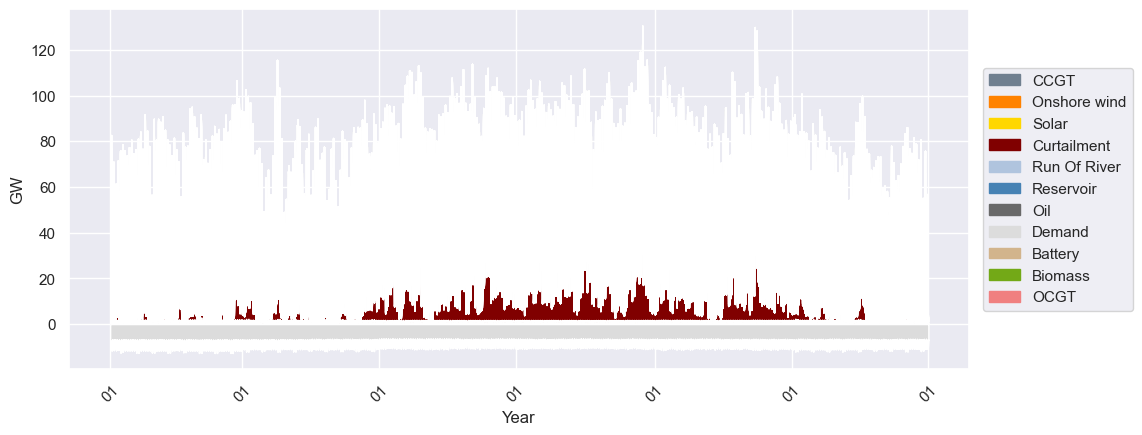

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  1.348857e+03
OCGT        1.850000e+02  1.855272e+02
biomass     1.050000e+01  1.061604e+01
coal        6.000000e+02  6.000010e+02
geothermal  1.350000e+02  8.613686e+03
load        6.700000e+10  6.700000e+10
offwind-ac  0.000000e+00  2.714196e+00
offwind-dc  0.000000e+00  1.502706e+00
oil         8.880000e+01  8.964852e+01
onwind      9.110989e-01  1.764118e+05
ror         6.017862e+02  6.017862e+02
solar       1.447202e+01  1.491341e+05

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


In [77]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-01-01"
second_date = "2014-01-01"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar + curtailment_wind

#Hourly generation per technology
CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]


#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = CCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = None

if "OCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
else:
    OCGT = None
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    


#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 



# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])


CCGT_color='slategrey'
Onwind_color='#ff8200'

Solar_color='gold'
curtailment_color = 'maroon'
ror_color='lightsteelblue'
reservoir_color='steelblue'
battery_color='tan'
oil_color='dimgrey'
biomass_color='#73A917'
demand_color='gainsboro'
lostload_color = "maroon"

# Prepare data for stackplot
stack_data = [CCGT, Onwind, solar, curtailment, ror, reservoir, pbattery, oil, load]
stack_colors = [CCGT_color, Onwind_color, Solar_color, curtailment_color, ror_color, reservoir_color, battery_color, oil_color, demand_color]

if biomass is not None:
    stack_data.append(biomass)
    stack_colors.append(biomass_color)

if OCGT is not None:
    stack_data.append(OCGT)
    stack_colors.append('lightcoral')

# Create the stackplot
plt.stackplot(CCGT.index, *stack_data, colors=stack_colors, zorder=3)


plt.stackplot(CCGT.index,demand,nbattery, colors=[demand_color,battery_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Year')


CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')

battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')

lostload_patch = mpatches.Patch(color=demand_color, label ='LostLoad')

handles = [
    CCGT_patch, wind_patch, solar_patch, curtailment_patch,
    ror_patch, reservoir_patch, oil_patch, load_patch, battery_patch
]

if biomass is not None:
    handles.append(biomass_patch)

if OCGT is not None:
    handles.append(mpatches.Patch(color='lightcoral', label='OCGT'))    

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = '.png' 


plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])


In [78]:
# List of generator carriers
generator_list = ["CCGT", "OCGT", "oil", "biomass", "geothermal", "onwind", "solar", "ror",""]

# Loop through each carrier in the generator list
for carrier in generator_list:
    # Filter generators by carrier and sum their generation
    if carrier in n.generators.carrier.unique():
        generation = n.generators_t.p.loc[:, n.generators[n.generators.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

# List of storage unit carriers
generator_list2 = ["hydro"]

# Loop through each carrier in the storage unit list
for carrier in generator_list2:
    # Filter storage units by carrier and sum their generation
    if carrier in n.storage_units.carrier.unique():
        generation = n.storage_units_t.p.loc[:, n.storage_units[n.storage_units.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

CCGT generation (MWh) = 2056664
OCGT generation (MWh) = 722
oil generation (MWh) = 3672
biomass generation (MWh) = 11111
geothermal generation (MWh) = 63820495
onwind generation (MWh) = 4303698
solar generation (MWh) = 5592319
ror generation (MWh) = 200982
 generation (MWh) = 0 (not present in the network)
hydro generation (MWh) = 1227298


Lost load

In [79]:
demand = n.loads_t.p_set.loc["2013"].sum(axis=1)
demand.idxmax()
demand.sum()

78849999.99998802

In [80]:
load_shedding = n.generators_t.p.loc["2013"].groupby(n.generators.carrier, axis=1).sum()["load"]
round(load_shedding.sum())

C:\Users\hie\AppData\Local\Temp\ipykernel_28804\1555212878.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



1627480989

In [81]:
#LL or Loadshedding is in kW/kWh 
lostload = n.generators_t.p.filter(like= "load")
#lostload.idxmax()
peakLL = pd.DataFrame(index = lostload.index)
peakLL["Peak LL"] = lostload.max(axis=1)/1000
sortedLL = peakLL.sort_values("Peak LL", ascending=False)
LL_contribution = sortedLL.iloc[0:9]
LL_contribution.mean()

Peak LL    615.744099
dtype: float64

In [82]:
#selecting generation capacities from statistics
# Load and process generation capacities
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line', 'Load', 'Link', 'Store'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0: "MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW'] / capacities['MW'].sum() * 100

# Define colors for each technology
H2_color = 'darkgoldenrod'
battery_color = 'tan'
demand_color = 'slategrey'
aggregated_small_capacities = 'black'

for i in range(len(capacities.index)):
    tech = capacities.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas":
        capacities.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas":
        capacities.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar":
        capacities.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River":
        capacities.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind":
        capacities.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam":
        capacities.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil":
        capacities.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal":
        capacities.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass":
        capacities.loc[tech, "Color"] = '#73A917'

# Handle small capacities
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), aggregated_small_capacities]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

# Plot installed capacities
plt.figure(figsize=(5, 5))
plt.pie(
    capacities['MW'], 
    labels=capacities.index, 
    colors=capacities['Color'], 
    autopct='%1.1f%%', 
    startangle=100, 
    pctdistance=0.85, 
    wedgeprops={'width': 0.4}
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

KeyError: "labels ['Link' 'Store'] not found in level"